In [55]:
import numpy as np
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F


%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
np.random.seed(1412)

In [67]:
price_quantity = np.random.randn(4100,2)

In [68]:
base_price_quantity = price_quantity[0]

In [69]:
initialDF = pd.DataFrame(price_quantity,columns=["price","quantity"])
initialDF.head()

,price,quantity
0,0.336519,0.506932
1,-0.098258,-0.705595
2,1.111341,-0.766724
3,1.079198,-2.110384
4,-0.651977,-1.507014


In [70]:
initialDF['cpi'] = pd.Series(initialDF["price"] * initialDF["quantity"]/base_price_quantity[0] * base_price_quantity[1])
initialDF.head()

,price,quantity,cpi
0,0.336519,0.506932,0.256980
1,-0.098258,-0.705595,0.104440
2,1.111341,-0.766724,-1.283591
3,1.079198,-2.110384,-3.430857
4,-0.651977,-1.507014,1.480095


In [12]:
cpi_index = pd.read_csv("data/CPIndex_Jan13-To-Jul19.csv")
cpi_index.head()

,Year,Month,State,Group,Sub Group,Description,Rural,Urban,Combined,Status
0,2013,January,ALL India,1,1.1.01,Cereals and products,107.5,110.5,108.4,F
1,2013,February,ALL India,1,1.1.01,Cereals and products,109.2,112.9,110.4,F
2,2013,March,ALL India,1,1.1.01,Cereals and products,110.2,113.9,111.4,F
3,2013,April,ALL India,1,1.1.01,Cereals and products,110.2,114.6,111.6,F
4,2013,May,ALL India,1,1.1.01,Cereals and products,110.9,115.4,112.3,F


In [13]:
list(cpi_index)

['Year',
 'Month',
 'State',
 'Group',
 'Sub Group',
 'Description',
 'Rural',
 'Urban',
 'Combined',
 'Status']

In [14]:
fuel_cpi_index = cpi_index[cpi_index.Group==1.0]
fuel_cpi_index = fuel_cpi_index[fuel_cpi_index["Sub Group"]=="1.1.02"]
fuel_cpi_index.head()

,Year,Month,State,Group,Sub Group,Description,Rural,Urban,Combined,Status
79,2013,January,ALL India,1,1.1.02,Meat and fish,106.3,109.1,107.3,F
80,2013,February,ALL India,1,1.1.02,Meat and fish,108.7,112.9,110.2,F
81,2013,March,ALL India,1,1.1.02,Meat and fish,108.8,111.4,109.7,F
82,2013,April,ALL India,1,1.1.02,Meat and fish,109.5,113.4,110.9,F
83,2013,May,ALL India,1,1.1.02,Meat and fish,109.8,114.2,111.3,F


In [15]:
combined_fuel_cpi = fuel_cpi_index[['Year', 'Month','Combined']]
months = {"January" : 1, "February" : 2, "March" : 3, "April" : 4, "May": 5, "June" : 6, "July" : 7, "August" : 8, "September" : 9, "October" : 10, "November" : 11, "December" : 12}
combined_fuel_cpi['Month'] = combined_fuel_cpi['Month'].map(lambda x: months[x])
combined_fuel_cpi['Timestamp'] = pd.to_datetime({'year' : combined_fuel_cpi['Year'], 'month' : combined_fuel_cpi['Month'], 'day':[1] * combined_fuel_cpi.shape[0]})
combined_fuel_cpi.head()

C:\Users\Lenovo\Anaconda3\envs\ml37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lenovo\Anaconda3\envs\ml37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Year,Month,Combined,Timestamp
79,2013,1,107.3,2013-01-01
80,2013,2,110.2,2013-02-01
81,2013,3,109.7,2013-03-01
82,2013,4,110.9,2013-04-01
83,2013,5,111.3,2013-05-01


In [16]:
combined_fuel_cpi = combined_fuel_cpi.set_index("Timestamp")
combined_fuel_cpi.head()

,Year,Month,Combined
Timestamp,,,
2013-01-01,2013,1,107.3
2013-02-01,2013,2,110.2
2013-03-01,2013,3,109.7
2013-04-01,2013,4,110.9
2013-05-01,2013,5,111.3


In [17]:
combined_fuel_cpi = combined_fuel_cpi.drop(["Year", "Month"], axis = 1)
combined_fuel_cpi.head()

,Combined
Timestamp,
2013-01-01,107.3
2013-02-01,110.2
2013-03-01,109.7
2013-04-01,110.9
2013-05-01,111.3


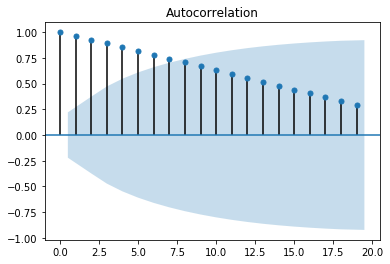

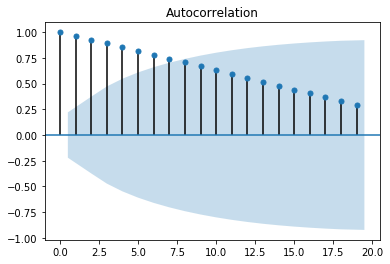

In [77]:
plot_acf(combined_fuel_cpi.values)

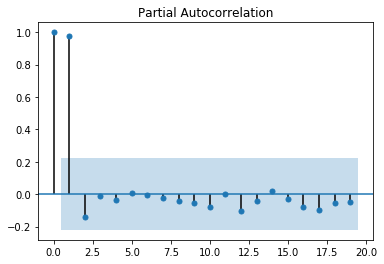

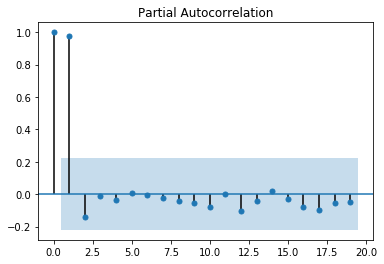

In [78]:
plot_pacf(combined_fuel_cpi.values)

In [151]:
total_dataset_size = len(combined_fuel_cpi.values)

In [152]:
arima_model = ARIMA(combined_fuel_cpi.values[:int(0.7 * total_dataset_size)], order = (8,1,0))

In [153]:
arima_results = arima_model.fit(disp=0)
arima_results.save("models/arima_model.pkl")

In [154]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   54
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -76.265
Method:                       css-mle   S.D. of innovations              0.968
Date:                Fri, 13 Sep 2019   AIC                            172.529
Time:                        16:09:35   BIC                            192.419
Sample:                             1   HQIC                           180.200
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6316      0.071      8.847      0.000       0.492       0.772
ar.L1.D.y      0.2648      0.130      2.043      0.047       0.011       0.519
ar.L2.D.y     -0.1028      0.143     -0.717      0.477      -0.384       0.178
ar.L3.D.y     -0.4656      0.148     -3.153      0.003      -0.755      -0.176
ar.L4.D.y      0.1857      0.162      1.147      0.258      -0.132       0.503
ar.L5.D.y     -0.3502      0.166     -2.106      0.041      -0.676      -0.024
ar.L6.D.y     -0.0632      0.163     -0.389      0.699      -0.382       0.255
ar.L7.D.y     -0.0048      0.156     -0.031      0.975      -0.311       0.301
ar.L8.D.y     -0.4493      0.140     -3.200      0.003      -0.724      -0.174
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9313           -0.5172j            1.0653           -0.0807
AR.2            0.9313           +0.5172j            1.0653            0.0807
AR.3            0.4608           -0.9793j            1.0823           -0.1800
AR.4            0.4608           +0.9793j            1.0823            0.1800
AR.5           -0.2985           -1.0992j            1.1390           -0.2922
AR.6           -0.2985           +1.0992j            1.1390            0.2922
AR.7           -1.0990           -0.2876j            1.1360           -0.4593
AR.8           -1.0990           +0.2876j            1.1360            0.4593
-----------------------------------------------------------------------------
"""

In [83]:
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

In [84]:
normalized_combined_fuel_cpi = normalize(combined_fuel_cpi)
normalized_combined_fuel_cpi.head()

,Combined
Timestamp,
2013-01-01,0.000000
2013-02-01,0.014006
2013-03-01,0.016807
2013-04-01,0.028011
2013-05-01,0.053221


In [85]:
normalized_arima_model = ARIMA(normalized_combined_fuel_cpi.values[:int(0.7 * total_dataset_size)], order = (2, 1, 0))
normalized_arima_model_results = normalized_arima_model.fit()
normalized_arima_model_results.save("models/normalized_arima_model.pkl")

In [86]:
normalized_arima_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   54
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 165.779
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 13 Sep 2019   AIC                           -323.558
Time:                        12:47:56   BIC                           -315.602
Sample:                             1   HQIC                          -320.489
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0126      0.002      7.146      0.000       0.009       0.016
ar.L1.D.y      0.3163      0.135      2.348      0.023       0.052       0.580
ar.L2.D.y     -0.1866      0.142     -1.313      0.195      -0.465       0.092
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8474           -2.1540j            2.3147           -0.1903
AR.2            0.8474           +2.1540j            2.3147            0.1903
-----------------------------------------------------------------------------
"""

In [155]:
print(combined_fuel_cpi.values[int(0.7 * total_dataset_size):])
forecasted_fuel_cpi = arima_results.forecast(total_dataset_size - int(0.7 * total_dataset_size))[0]
forecasted_fuel_cpi_df = pd.DataFrame(forecasted_fuel_cpi, index = combined_fuel_cpi[int(0.7 * total_dataset_size):].index, columns=['predicted_cpi'])
forecasted_fuel_cpi_df.head()
print(combined_fuel_cpi.values)
a=np.array(combined_fuel_cpi.values.tolist()[int(0.7 * total_dataset_size):]).flatten()
b=np.array(forecasted_fuel_cpi)

a = (a - np.mean(a)) / (np.std(a) )
b = (b - np.mean(b)) / (np.std(b))
print(len(a),len(b))
print(a,"\n",b)
c = np.correlate(a, b, 'same')
c= pd.DataFrame(c, index = combined_fuel_cpi[int(0.7 * total_dataset_size):].index, columns=['predicted_cpi'])*[forecasted_fuel_cpi]



[[143.4]
 [142.4]
 [142.2]
 [142.4]
 [143.3]
 [144.2]
 [143.5]
 [143.6]
 [144.4]
 [146.6]
 [148.7]
 [149.1]
 [148. ]
 [145.8]
 [146.7]
 [149.2]
 [150.5]
 [151.4]
 [152. ]
 [153. ]
 [155.3]
 [158.5]
 [162.1]
 [162.6]]
[[107.3]
 [110.2]
 [109.7]
 [110.9]
 [111.3]
 [114.9]
 [116.4]
 [117.2]
 [116.9]
 [116.3]
 [115.4]
 [116.7]
 [118.8]
 [119.2]
 [119.3]
 [119.9]
 [121.6]
 [123.1]
 [123.9]
 [124.4]
 [123.5]
 [123.8]
 [123.7]
 [123.2]
 [123.9]
 [125.1]
 [125.4]
 [126.4]
 [128. ]
 [131.8]
 [132.5]
 [131.4]
 [130.4]
 [129.8]
 [130.3]
 [131.4]
 [134.1]
 [134.2]
 [135.1]
 [136.8]
 [139.1]
 [140.5]
 [141.2]
 [139.3]
 [138. ]
 [137.9]
 [137.8]
 [137.6]
 [138.2]
 [138.8]
 [139. ]
 [139.4]
 [141.6]
 [145.5]
 [145.7]
 [143.4]
 [142.4]
 [142.2]
 [142.4]
 [143.3]
 [144.2]
 [143.5]
 [143.6]
 [144.4]
 [146.6]
 [148.7]
 [149.1]
 [148. ]
 [145.8]
 [146.7]
 [149.2]
 [150.5]
 [151.4]
 [152. ]
 [153. ]
 [155.3]
 [158.5]
 [162.1]
 [162.6]]
24 24
[-8.96210681e-01 -1.06517420e+00 -1.09896691e+00 -1.06517420e+00


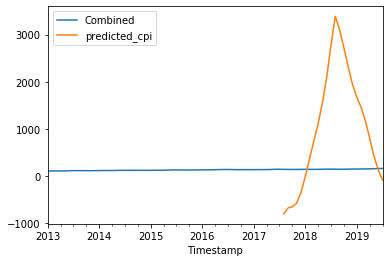

In [156]:
actual_forecasted_df = combined_fuel_cpi.join(c)#forecasted_fuel_cpi_df)
actual_forecasted_df.plot()

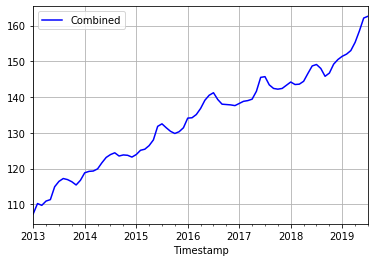

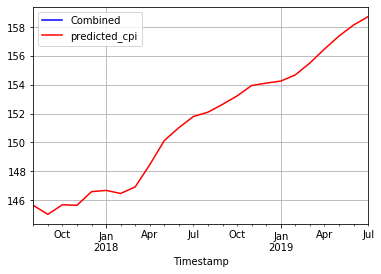

In [157]:
ax1 = combined_fuel_cpi.plot(color='blue', grid=True, label='Actual')
ax2 = forecasted_fuel_cpi_df.plot(color='red', grid = True, label = 'Forecasted')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()


In [112]:
print(normalized_combined_fuel_cpi.values[int(0.7 * total_dataset_size):])
normalized_arima_model_results.forecast(total_dataset_size - int(0.7 * total_dataset_size))[0]

[[0.61363636]
 [0.64393939]
 [0.67424242]
 [0.75252525]
 [0.78535354]
 [0.78535354]
 [0.78787879]
 [0.78282828]
 [0.78282828]
 [0.79292929]
 [0.82323232]
 [0.86363636]
 [0.89393939]
 [0.92929293]
 [0.95959596]
 [1.        ]
 [0.93939394]
 [0.85858586]
 [0.83080808]
 [0.86363636]
 [0.87121212]
 [0.87878788]
 [0.90151515]
 [0.8510101 ]]


array([0.61849982, 0.62894264, 0.64037427, 0.65158966, 0.66285234,
       0.67410467, 0.68535927, 0.69661337, 0.70786758, 0.71912177,
       0.73037596, 0.74163016, 0.75288435, 0.76413854, 0.77539273,
       0.78664692, 0.79790112, 0.80915531, 0.8204095 , 0.83166369,
       0.84291788, 0.85417208, 0.86542627, 0.87668046])

In [113]:
initialDF.head()

,price,quantity,cpi
0,2.336519,2.506932,6.284707
1,1.901742,1.294405,2.641161
2,3.111341,1.233276,4.117003
3,3.079198,-0.110384,-0.364684
4,1.348023,0.492986,0.713025


In [131]:
pd.date_range(end='2019-09-01',periods = 4100, freq = 'MS')

DatetimeIndex(['1678-02-01', '1678-03-01', '1678-04-01', '1678-05-01',
               '1678-06-01', '1678-07-01', '1678-08-01', '1678-09-01',
               '1678-10-01', '1678-11-01',
               ...
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01'],
              dtype='datetime64[ns]', length=4100, freq='MS')

In [155]:
initalDF_total_size = initialDF.shape[0]

In [156]:
initialDF = initialDF.set_index(pd.date_range(end='2019-09-01', periods = initalDF_total_size, freq = 'MS'))

In [157]:
initialDF = initialDF.drop(['price','quantity'], axis = 1)
initialDF.head()

,cpi
1678-02-01,0.152705
1678-03-01,0.411970
1678-04-01,-0.000222
1678-05-01,0.027525
1678-06-01,0.192640


In [175]:
initialDF_arima_model = ARIMA(initialDF.values[:int(0.7 * initalDF_total_size)], order = (1, 1, 1))
initialDF_arima_model_results = initialDF_arima_model.fit(disp = 0)
initialDF_arima_model_results.save("models/initialDF_arima_model.pkl")

In [176]:
initialDF_arima_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2869
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -818.922
Method:                       css-mle   S.D. of innovations              0.321
Date:                Tue, 10 Sep 2019   AIC                           1645.844
Time:                        18:14:41   BIC                           1669.691
Sample:                             1   HQIC                          1654.441
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.176e-05   7.02e-06      1.675      0.094      -2e-06    2.55e-05
ar.L1.D.y     -0.0340      0.019     -1.822      0.069      -0.071       0.003
ma.L1.D.y     -0.9999      0.001  -1009.069      0.000      -1.002      -0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -29.4083           +0.0000j           29.4083            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [164]:
print(initialDF.values[int(0.7 * initalDF_total_size): int(0.7 * initalDF_total_size) + 10])
print(initialDF_arima_model_results.forecast(10)[0])

[[ 0.1403513 ]
 [ 0.07503152]
 [ 0.24127928]
 [ 0.01450218]
 [ 0.07665108]
 [-0.05240045]
 [ 0.01934591]
 [-0.46488274]
 [-0.42913861]
 [-0.02519659]]
[0.02687004 0.02181415 0.02199823 0.02200413 0.02201608 0.02202783
 0.02203959 0.02205134 0.0220631  0.02207486]


## Torch regression

In [ ]:
# class RegModel(nn.Module):
#     input_dim = 2
#     hidden_dim = 10
#     output_dim = 1
#     def __init__(self):
#         super(RegModel, self).__init__()
#         self.layer1 = nn.Linear(input_dim, hidden_dim)
#         self.layer2 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         return self.layer2(nn.ReLU(self.layer1(x)))

# # model = nn.Linear(input, output)
# model = RegModel()
# # criterion = torch.nn.SmoothL1Loss()
# criterion = nn.MSELoss()
# optimizer = torch.optim.adam(model.parameters(), lr = 1e-4, weight_decay = 0.3)

In [ ]:
# for epoch in range(10):
# 	inputs = torch.from_numpy(x_train)
#     targets = torch.from_numpy(y_train)
#     outputs = model(inputs)
#     loss = criterion(outputs, targets)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     if (epoch + 1) % 5 == 0:
#         print(f"Epoch no. {epoch+1} , Loss: {loss.item()}")

# torch.save(model.state_dict(), 'model.ckpt')
# # model.load_state_dict(torch.load('model.ckpt'))


In [45]:
stepwise_fit = auto_arima(combined_fuel_cpi, start_p = 1, start_q = 1, max_p = 5, max_q = 3, m = 12, start_P=0, seasonal = True, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True, stepwise = True)
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=176.071, BIC=187.020, Fit time=1.719 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=199.556, BIC=203.935, Fit time=0.072 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=179.976, BIC=188.735, Fit time=1.429 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=175.263, BIC=184.022, Fit time=1.394 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=176.362, BIC=187.311, Fit time=5.482 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=180.884, BIC=187.453, Fit time=0.325 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=191.651, BIC=198.220, Fit time=1.202 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=175.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   79
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -83.632
Date:                            Fri, 13 Sep 2019   AIC                            175.263
Time:                                    12:16:20   BIC                            184.022
Sample:                                         0   HQIC                           178.724
                                             - 79                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0625      0.090     -0.695      0.487      -0.239       0.114
ma.L1          0.5485      0.110      4.982      0.000       0.333       0.764
ma.S.L12      -0.6187      0.257     -2.407      0.016      -1.122      -0.115
sigma2         0.6728      0.089      7.525      0.000       0.498       0.848
===================================================================================
Ljung-Box (Q):                       43.04   Jarque-Bera (JB):                66.00
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              11.76   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
combined_fuel_cpi_values = combined_fuel_cpi.values
size = int(len(combined_fuel_cpi_values) * 0.7)
train, test = combined_fuel_cpi_values[0:size], combined_fuel_cpi_values[size:len(X)]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    sm_model = ARIMA(history,order=(8,1,0))
    sm_model_fit = sm_model.fit(disp=0)
    print(sm_model_fit.summary())
    output = sm_model_fit.forecast()[0]
    predictions.append(output)
    real = test[i]
    history.append(real)
    print('prediction=%f,expected=%f' %(output,real))

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   54
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 -76.265
Method:                       css-mle   S.D. of innovations              0.968
Date:                Fri, 13 Sep 2019   AIC                            172.529
Time:                        16:16:39   BIC                            192.419
Sample:                             1   HQIC                           180.200
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6316      0.071      8.847      0.000       0.492       0.772
ar.L1.D.y      0.2648      0.130      2.043      0.047       0.011       0.519
ar.L2.D.y     -0.1028      0.143     -0.717      0.4

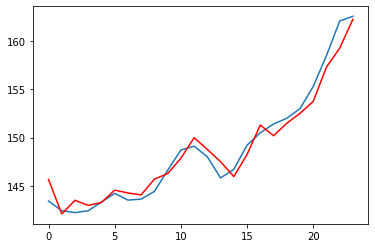

In [160]:
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

## Front end integration stuff

In [161]:
print(combined_fuel_cpi_values.flatten())

[107.3 110.2 109.7 110.9 111.3 114.9 116.4 117.2 116.9 116.3 115.4 116.7
 118.8 119.2 119.3 119.9 121.6 123.1 123.9 124.4 123.5 123.8 123.7 123.2
 123.9 125.1 125.4 126.4 128.  131.8 132.5 131.4 130.4 129.8 130.3 131.4
 134.1 134.2 135.1 136.8 139.1 140.5 141.2 139.3 138.  137.9 137.8 137.6
 138.2 138.8 139.  139.4 141.6 145.5 145.7 143.4 142.4 142.2 142.4 143.3
 144.2 143.5 143.6 144.4 146.6 148.7 149.1 148.  145.8 146.7 149.2 150.5
 151.4 152.  153.  155.3 158.5 162.1 162.6]


In [162]:
np.array(predictions).flatten()

array([145.63511789, 142.06480967, 143.47976023, 142.9542589 ,
       143.25334313, 144.53571344, 144.2388653 , 144.04306817,
       145.67989143, 146.25133556, 147.84808155, 149.9831274 ,
       148.7627739 , 147.48996609, 145.94555094, 148.2330205 ,
       151.29764144, 150.18524669, 151.4734686 , 152.51374589,
       153.75083806, 157.30964739, 159.28317531, 162.28299532])

In [163]:
actuals = pd.DataFrame(test, index = combined_fuel_cpi[int(0.7 * total_dataset_size):].index, columns=['Combined'])
actuals.head()

,Combined
Timestamp,
2017-08-01,143.4
2017-09-01,142.4
2017-10-01,142.2
2017-11-01,142.4
2017-12-01,143.3


In [164]:
forecasts = pd.DataFrame(predictions, index = combined_fuel_cpi[int(0.7 * total_dataset_size):].index, columns=['predicted_cpi'])
forecasts.shape

(24, 1)

In [165]:
final_df = actuals.join(forecasts)
final_df.head()

,Combined,predicted_cpi
Timestamp,,
2017-08-01,143.4,145.635118
2017-09-01,142.4,142.064810
2017-10-01,142.2,143.479760
2017-11-01,142.4,142.954259
2017-12-01,143.3,143.253343


In [166]:
k=final_df
print([dict(zip(['month','actual','predicted'],[str(index)[:10],i['Combined'],i['predicted_cpi']])) for index,i in k.iterrows()])

[{'month': '2017-08-01', 'actual': 143.4, 'predicted': 145.6351178886652}, {'month': '2017-09-01', 'actual': 142.4, 'predicted': 142.0648096738322}, {'month': '2017-10-01', 'actual': 142.2, 'predicted': 143.4797602255898}, {'month': '2017-11-01', 'actual': 142.4, 'predicted': 142.95425889977426}, {'month': '2017-12-01', 'actual': 143.3, 'predicted': 143.25334313491103}, {'month': '2018-01-01', 'actual': 144.2, 'predicted': 144.5357134351441}, {'month': '2018-02-01', 'actual': 143.5, 'predicted': 144.23886529964204}, {'month': '2018-03-01', 'actual': 143.6, 'predicted': 144.04306817109023}, {'month': '2018-04-01', 'actual': 144.4, 'predicted': 145.67989143124345}, {'month': '2018-05-01', 'actual': 146.6, 'predicted': 146.2513355600155}, {'month': '2018-06-01', 'actual': 148.7, 'predicted': 147.84808155185}, {'month': '2018-07-01', 'actual': 149.1, 'predicted': 149.983127399407}, {'month': '2018-08-01', 'actual': 148.0, 'predicted': 148.76277389563907}, {'month': '2018-09-01', 'actual': 

In [167]:
final_df.rename(columns={'Combined': 'actual_cpi'}, inplace = True)
final_df.head()

,actual_cpi,predicted_cpi
Timestamp,,
2017-08-01,143.4,145.635118
2017-09-01,142.4,142.064810
2017-10-01,142.2,143.479760
2017-11-01,142.4,142.954259
2017-12-01,143.3,143.253343


In [6]:
milk_prices_df = pd.read_csv("data/milk_prices.csv")
milk_prices_df.head()

,open,high,low,close,date,x,y
0,18.60,18.60,16.93,17.20,2013-01-02T00:00:00,1357084800000,17.20
1,17.25,17.39,16.95,16.98,2013-02-01T00:00:00,1359676800000,16.98
2,17.05,17.11,16.68,16.97,2013-03-01T00:00:00,1362096000000,16.97
3,16.95,17.68,16.94,17.60,2013-04-01T00:00:00,1364774400000,17.60
4,18.65,18.79,18.46,18.51,2013-05-01T00:00:00,1367366400000,18.51


In [7]:
milk_prices_df["date"] = milk_prices_df["date"].map(lambda x: x[:8]+"01")
milk_prices_df.head()

,open,high,low,close,date,x,y
0,18.60,18.60,16.93,17.20,2013-01-01,1357084800000,17.20
1,17.25,17.39,16.95,16.98,2013-02-01,1359676800000,16.98
2,17.05,17.11,16.68,16.97,2013-03-01,1362096000000,16.97
3,16.95,17.68,16.94,17.60,2013-04-01,1364774400000,17.60
4,18.65,18.79,18.46,18.51,2013-05-01,1367366400000,18.51


In [8]:
milk_prices_df.drop(columns = ["open", "high", "low", "x", "y"], axis = 1, inplace = True)

In [9]:
milk_prices_df.head()

,close,date
0,17.20,2013-01-01
1,16.98,2013-02-01
2,16.97,2013-03-01
3,17.60,2013-04-01
4,18.51,2013-05-01


In [10]:
milk_prices_df.rename(columns={'close': 'price'}, inplace = True)
milk_prices_df.head()

,price,date
0,17.20,2013-01-01
1,16.98,2013-02-01
2,16.97,2013-03-01
3,17.60,2013-04-01
4,18.51,2013-05-01


In [11]:
milk_prices_df.set_index("date", inplace = True)
milk_prices_df.head()

,price
date,
2013-01-01,17.20
2013-02-01,16.98
2013-03-01,16.97
2013-04-01,17.60
2013-05-01,18.51


In [27]:
# df = pd.read_csv("C:\Python35\projs\ml\cpi_prediction\data\CPIndex_Jan13-To-Jul19.csv"
# )
# df.drop(columns=["Rural", "Urban"], axis = 1, inplace = True)
# df.rename(columns = {"Combined": "CPI"}, inplace = True)
# df.head()

,Year,Month,State,Group,Sub Group,Description,CPI,Status
0,2013,January,ALL India,1,1.1.01,Cereals and products,108.4,F
1,2013,February,ALL India,1,1.1.01,Cereals and products,110.4,F
2,2013,March,ALL India,1,1.1.01,Cereals and products,111.4,F
3,2013,April,ALL India,1,1.1.01,Cereals and products,111.6,F
4,2013,May,ALL India,1,1.1.01,Cereals and products,112.3,F


In [76]:
combined_fuel_cpi.rename(columns = {"Combined" : "CPI"}, inplace = True)
milk_prices_cpi_df = milk_prices_df.join(combined_fuel_cpi)
milk_prices_cpi_df.dropna(inplace = True)

In [77]:
milk_prices_cpi_df.tail()

,price,CPI
date,,
2019-03-01,15.06,153.0
2019-04-01,15.96,155.3
2019-05-01,16.38,158.5
2019-06-01,16.27,162.1
2019-07-01,17.25,162.6


In [78]:
X, y = milk_prices_cpi_df["price"].values, milk_prices_cpi_df["CPI"].values
train_size, total_size = 0.7, len(X)
X_train, X_test = X[:int(train_size * total_size)], X[int(train_size * total_size):]
y_train, y_test = y[:int(train_size * total_size)], y[int(train_size * total_size):]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(55,) (24,) (55,) (24,)


In [94]:
class RegModel(nn.Module):
    input_dim = 1
    hidden_dim = 16
    output_dim = 1
    def __init__(self):
        super(RegModel, self).__init__()
        self.layer1 = nn.Linear(self.input_dim, self.hidden_dim, bias = True)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias = True)
        self.layer3 = nn.Linear(self.hidden_dim, self.output_dim, bias = True)
        self.dropout = nn.Dropout(p = 0.4)

    def forward(self, x):
        return self.layer3(self.dropout(F.relu(self.layer2(self.dropout(F.relu(self.layer1(x)))))))

In [95]:
del model
model = RegModel()
criterion = nn.SmoothL1Loss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 0.3)

for epoch in range(25000):
    inputs = torch.from_numpy(X.astype(np.float32))
    targets = torch.from_numpy(y.astype(np.float32))
    outputs = model(inputs.view(-1,1))
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch no. {epoch+1} , Loss: {loss.item()}")

torch.save(model.state_dict(), 'model.ckpt')
# model.load_state_dict(torch.load('model.ckpt'))

C:\Users\Lenovo\Anaconda3\envs\ml37\lib\site-packages\torch\nn\modules\loss.py:782: UserWarning: Using a target size (torch.Size([79])) that is different to the input size (torch.Size([79, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Epoch no. 500 , Loss: 117.79804229736328
Epoch no. 1000 , Loss: 93.19245910644531
Epoch no. 1500 , Loss: 57.51872253417969
Epoch no. 2000 , Loss: 49.47883605957031
Epoch no. 2500 , Loss: 41.8018684387207
Epoch no. 3000 , Loss: 43.388458251953125
Epoch no. 3500 , Loss: 42.12032699584961
Epoch no. 4000 , Loss: 43.30337142944336
Epoch no. 4500 , Loss: 39.680091857910156
Epoch no. 5000 , Loss: 39.077308654785156
Epoch no. 5500 , Loss: 41.064537048339844
Epoch no. 6000 , Loss: 38.60588455200195
Epoch no. 6500 , Loss: 39.655029296875
Epoch no. 7000 , Loss: 42.61482620239258
Epoch no. 7500 , Loss: 42.80813980102539
Epoch no. 8000 , Loss: 44.28901672363281
Epoch no. 8500 , Loss: 39.55311584472656
Epoch no. 9000 , Loss: 39.03763961791992
Epoch no. 9500 , Loss: 38.53883743286133
Epoch no. 10000 , Loss: 37.772796630859375
Epoch no. 10500 , Loss: 36.21251678466797
Epoch no. 11000 , Loss: 37.473670959472656
Epoch no. 11500 , Loss: 47.44541549682617
Epoch no. 12000 , Loss: 42.376277923583984
Epoch n

In [96]:
model.eval()
with torch.no_grad():
    test_input = torch.from_numpy(X_test.astype(np.float32))
    test_output = torch.from_numpy(y_test.astype(np.float32))
    outputs = model(test_input.view(-1,1))
    print(outputs)
    print(test_output)

tensor([[119.8213],
        [121.0877],
        [123.4799],
        [113.9817],
        [114.1928],
        [100.1214],
        [104.4836],
        [105.9611],
        [107.8607],
        [115.3889],
        [113.2782],
        [105.1871],
        [122.0727],
        [119.1881],
        [109.9010],
        [107.5793],
        [103.1468],
        [104.4836],
        [113.0671],
        [111.8007],
        [118.1328],
        [121.0877],
        [120.3138],
        [127.2088]])
tensor([143.4000, 142.4000, 142.2000, 142.4000, 143.3000, 144.2000, 143.5000,
        143.6000, 144.4000, 146.6000, 148.7000, 149.1000, 148.0000, 145.8000,
        146.7000, 149.2000, 150.5000, 151.4000, 152.0000, 153.0000, 155.3000,
        158.5000, 162.1000, 162.6000])
